# Task classifier

In [1]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np
from torchvision import transforms
import torch
import clip
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from rich import print
# to_pil = transforms.ToPILImage()


def find_avg_centroid(x):
    return np.mean(x, axis=0)

# def find_avg_centroid(x):
#     length, dim = x.shape
#     return np.array([np.sum(x[:, i])/length for i in range(dim)])

def find_nearest_centroids(x, y):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
        
    clf = NearestCentroid(metric='manhattan')
    clf = clf.fit(x, y)
    centroids = clf.centroids_
    return centroids

def find_knn(x, centroids, n_neighbors=10):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()

    knn_search = NearestNeighbors(n_neighbors=n_neighbors,
                            # metric='cosine', # because CLIP model
                            metric='manhattan', # because CLIP model
                            algorithm='auto', #'ball_tree'
                            n_jobs=-1)  
    knn_search.fit(x)

    indexes = knn_search.kneighbors(centroids, return_distance=False)
    return x[indexes][0]

        
def get_clusters(x):
    # X = mde_embedding
    # x = x.detach().cpu().numpy()
    # db = DBSCAN(eps=0.8, min_samples=10, n_jobs=-1, metric='manhattan').fit(X)
    # db = OPTICS(min_samples=2).fit(x)
    db = DBSCAN(eps=0.3, min_samples=10, leaf_size=30, 
                n_jobs=-1, metric='cosine').fit(x)

    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    # core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    if n_clusters_ == 0:
        return x, labels, n_clusters_
    # Remove outliers to avoid affecting the centroids
    x = x[np.where(labels != -1)]
    labels = labels[np.where(labels != -1)]
    
    return x, labels, n_clusters_


def get_nearest_embedding_centroids(x, n_neighbors=10):
    # print(task.task.title())
    # print(f"CLIP Embedding shape: {task.embeddings.shape}")
    
    #1. Get the CLIP embeddings
    if not isinstance(x, (np.ndarray, np.generic)):
        x = x.detach().cpu().numpy()
    
    #3. Cluster the embeddings
    x, labels, n_clusters = get_clusters(x)

    #4. Find centroids of embeddings
    if n_clusters < 2:
        centroids = find_avg_centroid(x)
        centroids = centroids.reshape(1, -1)
    else:
        centroids = find_nearest_centroids(x, labels)

    # If some infinite/nan values appear
    centroids = np.nan_to_num(centroids)
    #5. Find knn of centroids        
    x_nearest_centroids = find_knn(x, centroids, n_neighbors)
    # x_nearest_centroids2 = np.vstack([find_knn(x, [centroid], n_neighbors) for centroid in centroids])
    # return centroids
    x_chosen = np.vstack([centroids, x_nearest_centroids])
    # x_chosen = np.vstack([centroids, x_nearest_centroids, x_nearest_centroids2])
    print(f"# nearest centroids ({round((x_chosen.shape[0]/x.shape[0])*100, 2)}%):", x_chosen.shape)
    print()

    return x_chosen


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
embeder, preprocess = clip.load("ViT-B/32", device=device)

Device:  cpu

In [3]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, util
from functools import lru_cache

@lru_cache(maxsize=None)
def get_embeddings(dataset):
    
    all_features = []
    all_labels = []
    all_tasks = []
    
    with torch.no_grad():
        for images, labels, tasks in tqdm(DataLoader(dataset, batch_size=100, num_workers=8)):
            features = embeder.encode_image(images.to(device))
            # features = embeder_resnet(images.to(device)).squeeze()

            all_features.append(features)
            all_labels.append(labels)
            all_tasks.append(tasks)

    return (torch.cat(all_features).cpu().numpy(), 
            torch.cat(all_labels).cpu().numpy(), torch.cat(all_tasks).cpu().numpy())


In [4]:
import sys
sys.path.append('./CLAD/')

In [5]:
import clad
import torchvision

root = "./data"
original_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.3252, 0.3283, 0.3407), (0.0265, 0.0241, 0.0252))

])

# all_train_sets = clad.get_cladc_train(root, transform=lambda x: x)
all_train_sets = clad.get_cladc_train(root, transform=original_transform)
# val_sets = clad.get_cladc_val(root, transform=torchvision.transforms.ToTensor())
print(len(all_train_sets))
print([len(ts) for ts in all_train_sets])

[INFO] No Detectron installation found, continuing without.


6

[5157, 1154, 6742, 2560, 4517, 2119]

In [6]:
# method_transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.ToPILImage()
# ])
method_transform = torchvision.transforms.Compose([
    preprocess
])
all_train_sets_method = clad.get_cladc_train(root, transform=method_transform)
print(len(all_train_sets_method))
print([len(ts) for ts in all_train_sets_method])

6

[5157, 1154, 6742, 2560, 4517, 2119]

In [7]:
import torch
from torch.utils.data import random_split

# Define the split sizes for each dataset
train_size = 0.8
# test_size = 0.2

# Split each dataset in the train_sets list into training and testing sets
train_sets = []
test_sets = []
for dataset in all_train_sets:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets.append(train_dataset)
    test_sets.append(test_dataset)

print("Original data")
print('Training lenghts: ', [len(ts) for ts in train_sets])
print('Testing lenghts: ', [len(ts) for ts in test_sets])

train_sets_method = []
test_sets_method = []
for dataset in all_train_sets_method:
    dataset_size = len(dataset)
    train_dataset_size = int(train_size * dataset_size)
    test_dataset_size = dataset_size - train_dataset_size
    train_dataset, test_dataset = random_split(dataset, [train_dataset_size, test_dataset_size], 
                                               generator=torch.Generator().manual_seed(42))
    train_sets_method.append(train_dataset)
    test_sets_method.append(test_dataset)

print("Method data")
print('Training lenghts: ', [len(ts) for ts in train_sets_method])
print('Testing lenghts: ', [len(ts) for ts in test_sets_method])

Original data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

Method data

Training lenghts: 
[4125, 923, 5393, 2048, 3613, 1695]

Testing lenghts: 
[1032, 231, 1349, 512, 904, 424]

In [8]:
%%time
from torch.utils.data.dataset import TensorDataset
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.utils import make_classification_dataset
from torch.utils.data import DataLoader
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark



# Original benchmark with tasks
training_datasets = list()
testing_datasets = list()

for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Original benchmark without tasks
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets, test_sets), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(0, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(0, len(test_s))))

benchmark_no_task= dataset_benchmark(
    training_datasets,
    testing_datasets
)

# Method benchmark
training_datasets = list()
testing_datasets = list()
for task, (train_s, test_s) in enumerate(zip(train_sets_method, test_sets_method), start=0):
    training_datasets.append(make_classification_dataset(train_s, task_labels=np.repeat(task, len(train_s))))
    testing_datasets.append(make_classification_dataset(test_s, task_labels=np.repeat(task, len(test_s))))

benchmark_method= dataset_benchmark(
    training_datasets,
    testing_datasets
)

CPU times: user 511 ms, sys: 147 ms, total: 659 ms
Wall time: 712 ms


## Data preparation

In [9]:
train_stream = benchmark_method.train_stream
test_stream = benchmark_method.test_stream

all_x_train_emb = list()
all_y_train = list()
all_t_train = list()

all_x_test_emb = list()
all_y_test = list()
all_t_test = list()


for task, experience in enumerate(train_stream):
    print("Getting embeddings")
    x_train_emb, y_train, t_train = get_embeddings(train_stream[task].dataset)

    print("x_train shape: ", x_train_emb.shape)
    all_x_train_emb.append(x_train_emb)
    all_y_train.append(y_train)
    all_t_train.append(t_train)

    x_test_emb, y_test, t_test = get_embeddings(test_stream[task].dataset)
    print("x_test shape: ", x_test_emb.shape)
    all_x_test_emb.append(x_test_emb)
    all_y_test.append(y_test)
    all_t_test.append(t_test)

Getting embeddings

100%|██████████| 42/42 [00:33<00:00,  1.25it/s]


x_train shape: 
(4125, 512)

100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


x_test shape: 
(1032, 512)

Getting embeddings

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


x_train shape: 
(923, 512)

100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


x_test shape: 
(231, 512)

Getting embeddings

100%|██████████| 54/54 [00:37<00:00,  1.45it/s]


x_train shape: 
(5393, 512)

100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


x_test shape: 
(1349, 512)

Getting embeddings

100%|██████████| 21/21 [00:15<00:00,  1.33it/s]


x_train shape: 
(2048, 512)

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


x_test shape: 
(512, 512)

Getting embeddings

100%|██████████| 37/37 [00:25<00:00,  1.45it/s]


x_train shape: 
(3613, 512)

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


x_test shape: 
(904, 512)

Getting embeddings

100%|██████████| 17/17 [00:14<00:00,  1.15it/s]


x_train shape: 
(1695, 512)

100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


x_test shape: 
(424, 512)

In [12]:
%%time
n_range = 4
x_train_knn_total = [get_nearest_embedding_centroids(task, n_neighbors=30) for task in all_x_train_emb[:n_range]]
print("x_train_knn shape: ", [e.shape[0] for e in x_train_knn_total])
y_train_knn_total = [all_t_train[i][:x_train_knn_total[i].shape[0]] for i in range(len(all_t_train[:n_range]))]
x_train_knn_total = np.vstack(x_train_knn_total)
y_train_knn_total = np.hstack(y_train_knn_total)
print(x_train_knn_total.shape)
print("y_train_knn_total ", y_train_knn_total.shape)

print()
print("Testing")
print("x_test shape: ", [e.shape[0] for e in all_x_test_emb[:n_range]])
x_test_total = np.vstack(all_x_test_emb[:n_range])
y_test_total = np.hstack(all_t_test[:n_range])
print("x_test_total ", x_test_total.shape)
print("y_test_total ", y_test_total.shape)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.75%):
(31, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (3.36%):
(31, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (0.57%):
(31, 512)

Estimated number of clusters: 1

Estimated number of noise points: 0

# nearest centroids (1.51%):
(31, 512)

x_train_knn shape: 
[31, 31, 31, 31]

(124, 512)

y_train_knn_total 
(124,)

Testing

x_test shape: 
[1032, 231, 1349, 512]

x_test_total 
(3124, 512)

y_test_total 
(3124,)

CPU times: user 39 s, sys: 39.5 s, total: 1min 18s
Wall time: 1.6 s


## Nearest Centroid

In [13]:
clf = NearestCentroid(metric='manhattan')
clf = clf.fit(x_train_knn_total, y_train_knn_total)
print(f"score training knn: {clf.score(x_train_knn_total, y_train_knn_total)}")
print(f"score testing: {clf.score(x_test_total, y_test_total)}")

score training knn: 0.9596774193548387

score testing: 0.7170294494238156

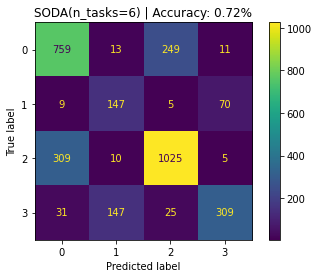

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(clf, x_val_total, y_val_total)  
predictions = clf.predict(x_test_total)
cm = confusion_matrix(y_test_total, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)

disp.plot()
plt.title(f"SODA(n_tasks=6) | Accuracy: {round(clf.score(x_test_total, y_test_total), 2)}%")
plt.show();

## Logistic Regression

In [15]:
%%time

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform

def scale_data(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled

def train_logistic_regression(x_train, y_train, params):
    logistic = LogisticRegression(**params)
    logistic.fit(x_train, y_train)
    return logistic



logistic_params = {
    'solver': 'saga',
    'max_iter': 20, 
    'multi_class': 'multinomial',
    'random_state': 42,
    'C': 0.018781904770188262,
    'penalty': 'l2',
    'n_jobs': -1 
}

x_train_scaled, x_test_scaled = scale_data(x_train_knn_total, x_test_total)
logistic_model = train_logistic_regression(x_train_scaled, y_train_knn_total, logistic_params)
test_score = logistic_model.score(x_test_scaled, y_test_total)

print(f"Model testing score: {test_score}")

/opt/intel/oneapi/intelpython/latest/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model testing score: 0.7688860435339309

CPU times: user 17 ms, sys: 238 ms, total: 255 ms
Wall time: 56.4 ms


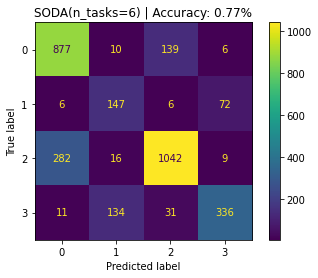

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
# plot_confusion_matrix(clf, x_val_total, y_val_total)  
predictions = logistic_model.predict(x_test_scaled)
cm = confusion_matrix(y_test_total, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)

disp.plot()
plt.title(f"SODA(n_tasks=6) | Accuracy: {round(logistic_model.score(x_test_scaled, y_test_total), 2)}%")
plt.show();